In [307]:
# ================================================
# 1. Importar librerías
# ================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Configuración estética
plt.rcParams['figure.figsize'] = (10,6)
sns.set(style="whitegrid")

In [308]:
# ================================================
# 2. Cargar datos (funciona CSV o XLSX)
# ================================================
# Cambia el archivo según el formato que tengas
file = "citybike_lima.csv"   # o "citybike_lima.xlsx"

if file.endswith(".csv"):
    df = pd.read_csv(file)
elif file.endswith(".xlsx"):
    df = pd.read_excel(file)

print("Dimensiones del dataset:", df.shape)
df.head()


Dimensiones del dataset: (5288, 17)


,scrape_timestamp,station_id,station_name,lat,lon,capacity,free_bikes,empty_slots,day_of_week,periodo_dia,weather_main,weather_desc,temp_C,wind_speed,clima_miraflores,temp_miraflores,in_miraflores
0,2025-10-01T11:34:22.005486-05:00,008a35afc6b4060be57b48bf90bec44c,18027 Ov. Julio Ramón Riveyro - Av. Pardo,-12.119013,-77.039928,14,8,6,Wednesday,mañana,NaN,NaN,19.0,NaN,Clima: pronóstico del tiempo,19.0,True
1,2025-10-01T11:34:22.005486-05:00,03367da30caea302b11c838d8b98df55,18009 Ca. Luis Schereiber Cdra. 2 (C.C. Aurora),-12.122125,-77.011506,16,8,8,Wednesday,mañana,NaN,NaN,19.0,NaN,Clima: pronóstico del tiempo,19.0,False
2,2025-10-01T11:34:22.005486-05:00,06dd87a8b87232577015b1c9a4ba08ed,18024 Ov. Bolognesi - Ca. Madrid,-12.123368,-77.035637,14,3,11,Wednesday,mañana,NaN,NaN,19.0,NaN,Clima: pronóstico del tiempo,19.0,True
3,2025-10-01T11:34:22.005486-05:00,0927eccbf04e2aadd179595c55c52bbe,18047 Malecón Cisneros - Ca. Trípoli,-12.125037,-77.037307,16,9,7,Wednesday,mañana,NaN,NaN,19.0,NaN,Clima: pronóstico del tiempo,19.0,True
4,2025-10-01T11:34:22.005486-05:00,0ac132eb1a147b7b23a753185cbebd1d,18026 Malecón de la Marina - Parque Grau,-12.118497,-77.045048,20,11,9,Wednesday,mañana,NaN,NaN,19.0,NaN,Clima: pronóstico del tiempo,19.0,True


In [309]:
# ================================================
# 3. Revisión inicial
# ================================================
print("\nTipos de datos:")
print(df.dtypes)

print("\nNulos por columna:")
print(df.isnull().sum())

print("\nDuplicados:", df.duplicated().sum())




Tipos de datos:
scrape_timestamp     object
station_id           object
station_name         object
lat                 float64
lon                 float64
capacity              int64
free_bikes            int64
empty_slots           int64
day_of_week          object
periodo_dia          object
weather_main        float64
weather_desc        float64
temp_C              float64
wind_speed          float64
clima_miraflores     object
temp_miraflores     float64
in_miraflores          bool
dtype: object

Nulos por columna:
scrape_timestamp       0
station_id             0
station_name           0
lat                    0
lon                    0
capacity               0
free_bikes             0
empty_slots            0
day_of_week            0
periodo_dia            0
weather_main        5288
weather_desc        5288
temp_C                 0
wind_speed          5288
clima_miraflores       0
temp_miraflores        0
in_miraflores          0
dtype: int64

Duplicados: 0


In [310]:
# Renombrar variables clave
df = df.rename(columns={
    "scrape_timestamp": "timestamp",
    "station_id": "id_estacion",
    "station_name": "nombre_estacion",
    "lat": "latitud",
    "lon": "longitud",
    "capacity": "capacidad",
    "free_bikes": "bicis_libres",
    "empty_slots": "espacios_vacios",
    "day_of_week": "dia_semana",
    "weather_main": "clima_general",
    "weather_desc": "clima_detalle",
    "temp_C": "temp_c",
    "wind_speed": "vel_viento",
    "clima_miraflores": "clima_miraflores",
    "temp_miraflores": "temp_miraflores",
    "in_miraflores": "en_miraflores"
})

# No eliminar filas si clima está vacío → solo no usar esas columnas
df = df.dropna(subset=["bicis_libres", "espacios_vacios", "capacidad"])
df["dia_semana"] = df["dia_semana"].astype(str).str.strip()

# tipos numéricos
for c in ['bicis_libres','capacidad','espacios_vacios','temp_c','lat','lon']:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors='coerce')

# Crear variable de ocupación
df["ocupacion"] = df["bicis_libres"] / df["capacidad"]
df["ocupacion"] = df["ocupacion"].clip(0, 1)
df["ocupacion"] = df["ocupacion"].round(2)

In [311]:
# Timestamp
if "timestamp" in df.columns:
    df["timestamp"] = pd.to_datetime(df["timestamp"])
else:
    raise KeyError("⚠️ No se encontró la columna de timestamp")

df["hora"] = df["timestamp"].dt.hour
df["fecha"] = df["timestamp"].dt.date

# Si no hay día de semana explícito, derivarlo
if df["dia_semana"].nunique() <= 1:
    df["dia_semana"] = df["timestamp"].dt.day_name(locale="es_ES")
    df["dia_semana"] = df["dia_semana"].str.slice(0,3)  # Lun, Mar, etc.
    dias_orden = ["Lun", "Mar", "Mié", "Jue", "Vie", "Sáb", "Dom"]
    df["dia_semana"] = pd.Categorical(df["dia_semana"], categories=dias_orden, ordered=True)
# ocupacion safe
df['ocupacion'] = np.where(df['capacidad']>0, df['bicis_libres']/df['capacidad'], np.nan)
df['ocupacion'] = df['ocupacion'].clip(0,1)


In [312]:
# ================================================
# 7. Estadísticas descriptivas
# ================================================
print("\nResumen estadístico:")
print(df.describe(include="all"))



Resumen estadístico:
                                  timestamp                       id_estacion  \
count                                  5288                              5288   
unique                                  NaN                                51   
top                                     NaN  008a35afc6b4060be57b48bf90bec44c   
freq                                    NaN                               105   
mean    2025-10-02 15:52:40.524101376-05:00                               NaN   
min        2025-10-01 11:34:22.005486-05:00                               NaN   
25%     2025-10-02 01:22:40.491671040-05:00                               NaN   
50%     2025-10-02 15:16:24.257547008-05:00                               NaN   
75%     2025-10-03 06:38:44.109725952-05:00                               NaN   
max        2025-10-03 22:43:10.245499-05:00                               NaN   
std                                     NaN                               NaN   

     

In [313]:
# ================================================
# 8. Análisis por estación
# ================================================
station_summary = df.groupby("id_estacion").agg(
    nombre_estacion=("nombre_estacion", "first"),
    obs=("id_estacion","count"),
    bicis_promedio=("bicis_libres","mean"),
    capacidad_promedio=("capacidad","mean"),
    ocupacion_promedio=("ocupacion","mean"),
    pct_vacia=("bicis_libres", lambda x: (x==0).mean()*100),
    pct_llena=("espacios_vacios", lambda x: (x==0).mean()*100),
    hora_pico=("hora", lambda x: x.value_counts().idxmax())
).reset_index()

station_summary.sort_values("pct_vacia", ascending=False).head(10)
station_summary.sort_values("pct_llena", ascending=False).head(10)
station_summary.sort_values("ocupacion_promedio").head(10)

,id_estacion,nombre_estacion,obs,bicis_promedio,capacidad_promedio,ocupacion_promedio,pct_vacia,pct_llena,hora_pico
17,6369e20f974a82f599ac39793a9ceeef,27042 Av. P. Carriquiry - Av. Ricardo Angulo,38,0.000000,16.0,0.000000,100.000000,0.0,11
50,eff5bc44fad7421819820f56aa6ded68,18012 Ca. Ignacio La Puente - Av. Benavides,105,3.561905,20.0,0.178095,0.000000,0.0,11
39,b01138adb0102e1f6862bb8ba54b9721,18014 Ca. Ramon Ribeyro - Av. Benavides,105,5.152381,24.0,0.214683,0.000000,0.0,11
19,66ba95532fd0758049c624f5a08d8e4d,18007 Ca. Schell - Av. La Paz,105,4.857143,20.0,0.242857,0.000000,0.0,11
21,696787ac674aad03dc56a790f1f9e6ed,18033 Ca. Scipión Llona Cdra.3,105,4.085714,16.0,0.255357,0.952381,0.0,11
27,758f33f3320ac4a7aca286cf7e57bef4,18038 Ca. Gral. Borgoño - Ca. Ayacucho,105,5.219048,20.0,0.260952,0.000000,0.0,11
14,55c0bf37006a2c06875866c6e9e13156,18039 Psje. Juana Alarco De Dammert - Ov. Guti...,105,4.752381,18.0,0.264021,0.000000,0.0,11
48,eb0b102f9e9bb933d2194064e70496ad,18032 Ca. Gral. Suarez - Av .Angamos Oeste,105,4.780952,18.0,0.265608,0.000000,0.0,11
26,757937ea9bcfaefaef0a20a336c024cf,18028 Av. Jorge Chávez - Av. Jose Pardo,105,5.971429,20.0,0.298571,0.000000,0.0,11
44,c87a72c82867fcd9f59503de195895b3,18035 Ca. Santander - Av. Santa Cruz,105,3.590476,12.0,0.299206,0.952381,0.0,11


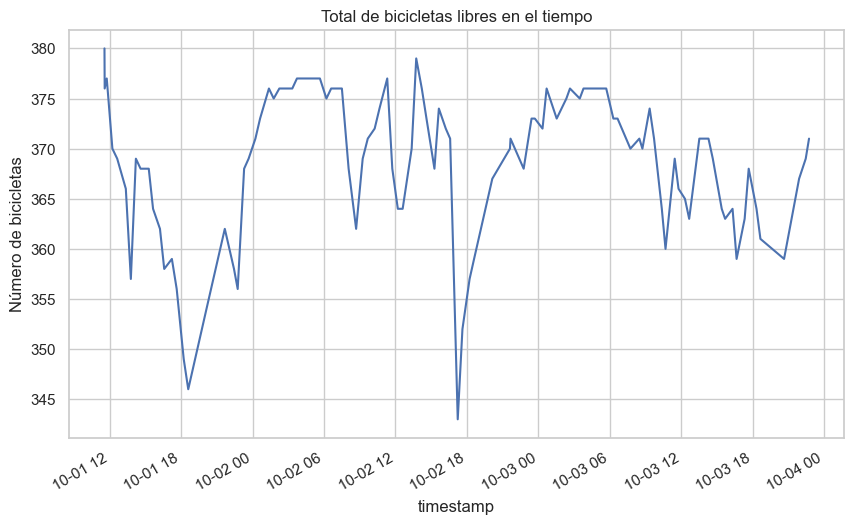

In [314]:
# ================================================
# 9. Series temporales
# ================================================
total_bikes = df.groupby("timestamp")["bicis_libres"].sum()
total_bikes.plot(title="Total de bicicletas libres en el tiempo")
plt.ylabel("Número de bicicletas")
plt.show()



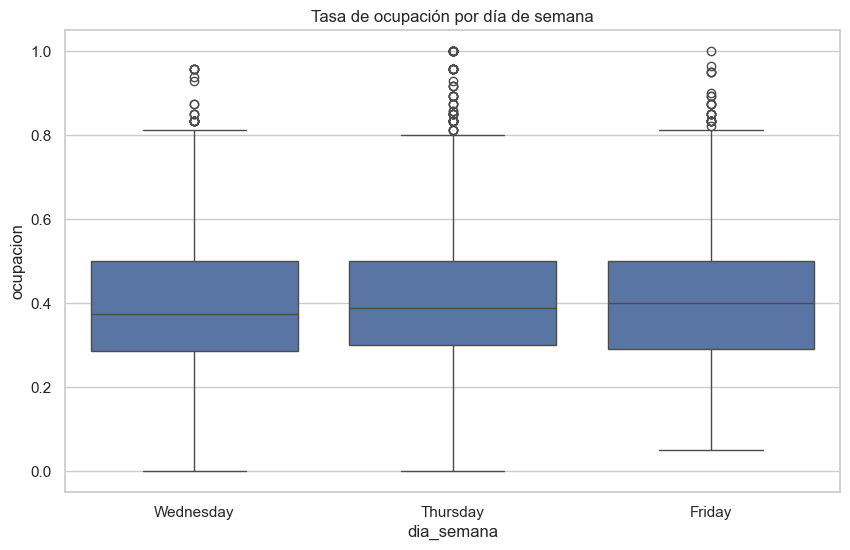

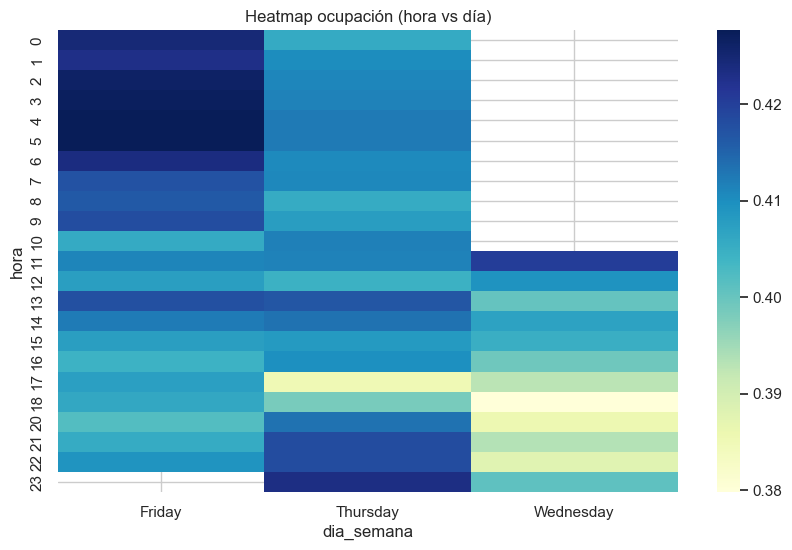

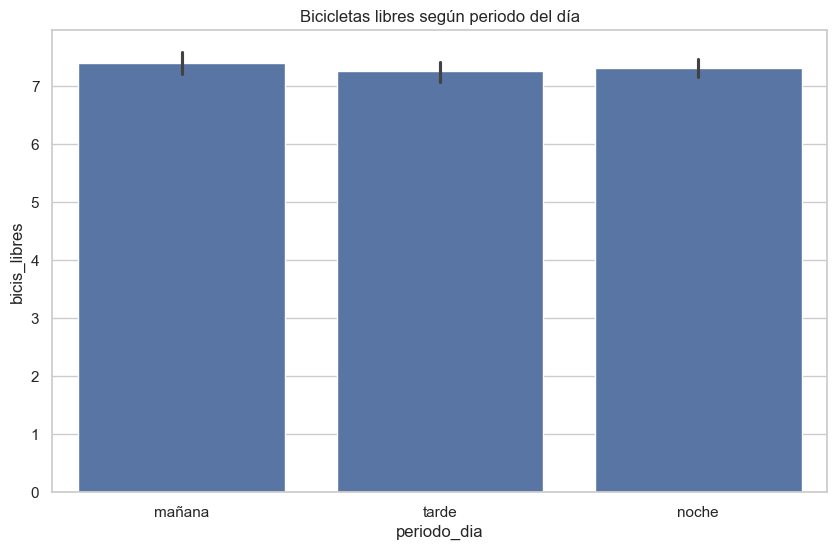

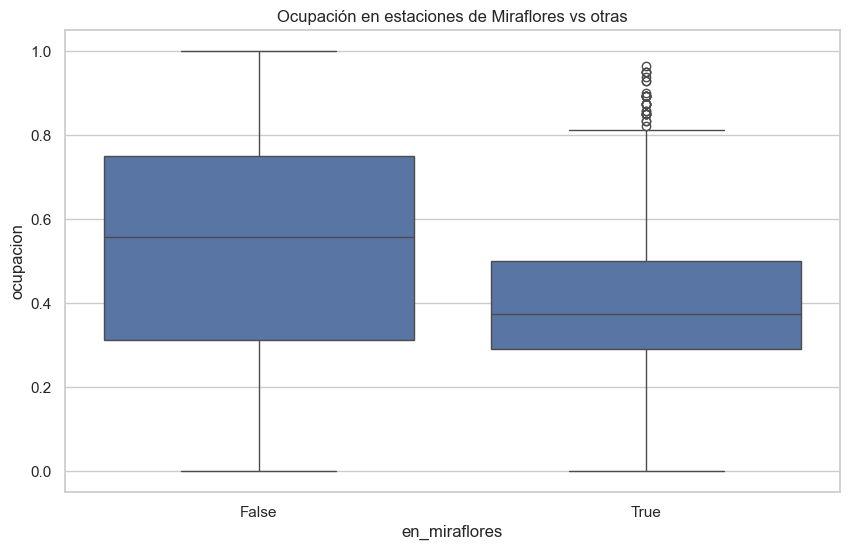

In [315]:

# ================================================
# 10. Distribuciones
# ================================================
# Evitar problemas si hay pocos días
# Boxplot por día de semana
if df["dia_semana"].nunique() > 1:
    sns.boxplot(x="dia_semana", y="ocupacion", data=df)
    plt.title("Tasa de ocupación por día de semana")
    plt.show()

# Heatmap hora vs día
pivot = df.pivot_table(index="hora", columns="dia_semana", values="ocupacion", aggfunc="mean")
if not pivot.empty:
    sns.heatmap(pivot, cmap="YlGnBu")
    plt.title("Heatmap ocupación (hora vs día)")
    plt.show()

# Bicicletas según clima (solo si hay datos útiles)
if df["clima_general"].nunique() > 1:
    sns.boxplot(x="clima_general", y="bicis_libres", data=df)
    plt.title("Bicicletas libres según clima")
    plt.xticks(rotation=45)
    plt.show()

# Periodo del día
sns.barplot(x="periodo_dia", y="bicis_libres", data=df, estimator=np.mean)
plt.title("Bicicletas libres según periodo del día")
plt.show()

# Miraflores vs resto
sns.boxplot(x="en_miraflores", y="ocupacion", data=df)
plt.title("Ocupación en estaciones de Miraflores vs otras")
plt.show()




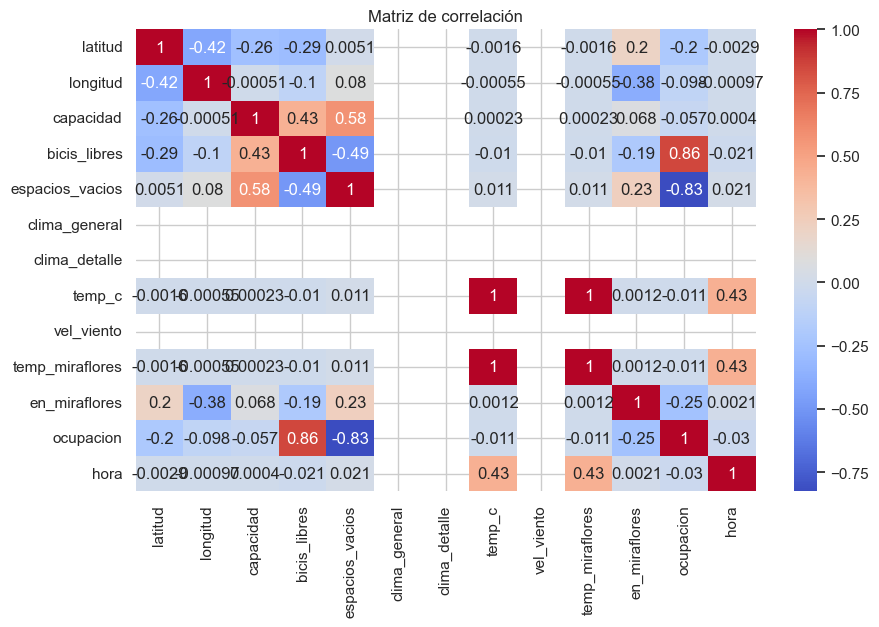

In [316]:


# ================================================
# 12. Matriz de correlación
# ================================================
corr = df.corr(numeric_only=True)
sns.heatmap(corr, cmap="coolwarm", annot=True)
plt.title("Matriz de correlación")
plt.show()




In [317]:
# quintiles (balance)
df['ocup_cat_q'] = pd.qcut(df['ocupacion'].dropna(), q=3, labels=['Q1','Q2','Q3'])
# categorías fijas (útiles operativamente)
bins = [0.15,0.35,0.55,0.75]
labels = ['Baja','Media','Alta']
df['ocup_cat_fixed'] = pd.cut(df['ocupacion'], bins=bins, labels=labels, include_lowest=True)

# --- Conteo por categoría fija ---

conteo_categorias = df['ocup_cat_fixed'].value_counts().reindex(labels)
print("Conteo por categorias fijas:")
print(df['ocup_cat_fixed'].value_counts().reindex(labels))


Conteo por categorias fijas:
ocup_cat_fixed
Baja     1994
Media    2027
Alta      867
Name: count, dtype: int64


In [318]:
agg_hour = df.dropna(subset=['ocup_cat_fixed','ocupacion']).groupby(['ocup_cat_fixed','hora']).agg(
    mean_ocup=('ocupacion','mean'),
    n_obs=('ocupacion','count')
).reset_index()

pivot_hour = agg_hour.pivot(index='hora', columns='ocup_cat_fixed', values='mean_ocup')
pivot_hour.to_csv('pivot_hour_mean_ocup.csv')   # opcional: guardar
print(pivot_hour.head(24))


ocup_cat_fixed      Baja     Media      Alta
hora                                        
0               0.278867  0.430405  0.644122
1               0.282440  0.429652  0.648241
2               0.275949  0.431074  0.650372
3               0.274876  0.434165  0.643452
4               0.272720  0.436392  0.641890
5               0.272720  0.436392  0.641890
6               0.261028  0.436277  0.646755
7               0.258089  0.432789  0.633201
8               0.261561  0.447341  0.653685
9               0.270359  0.441005  0.652917
10              0.274160  0.436432  0.633024
11              0.265697  0.439207  0.650061
12              0.269595  0.436190  0.644058
13              0.278663  0.443003  0.656444
14              0.271042  0.438787  0.652631
15              0.274967  0.429792  0.654357
16              0.274283  0.435396  0.665196
17              0.258843  0.425239  0.650389
18              0.255280  0.437161  0.644563
20              0.266264  0.438560  0.657928
21        

C:\Users\curay\AppData\Local\Temp\ipykernel_4512\3533509644.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  agg_hour = df.dropna(subset=['ocup_cat_fixed','ocupacion']).groupby(['ocup_cat_fixed','hora']).agg(


In [319]:
station_summary = df.groupby('id_estacion').agg(
    nombre_estacion=('nombre_estacion', lambda x: x.mode().iloc[0] if len(x.dropna())>0 else ""),
    obs=('timestamp','count'),
    mean_bicis=('bicis_libres','mean'),
    mean_capacidad=('capacidad','mean'),
    mean_ocupacion=('ocupacion','mean')
).reset_index()

station_summary['ocup_cat_fixed'] = pd.cut(station_summary['mean_ocupacion'].fillna(0), bins=bins, labels=labels, include_lowest=True)
station_summary.to_csv('station_summary_with_cat.csv', index=False)
station_summary.sort_values('mean_ocupacion').head(100)


,id_estacion,nombre_estacion,obs,mean_bicis,mean_capacidad,mean_ocupacion,ocup_cat_fixed
17,6369e20f974a82f599ac39793a9ceeef,27042 Av. P. Carriquiry - Av. Ricardo Angulo,38,0.000000,16.0,0.000000,NaN
50,eff5bc44fad7421819820f56aa6ded68,18012 Ca. Ignacio La Puente - Av. Benavides,105,3.561905,20.0,0.178095,Baja
39,b01138adb0102e1f6862bb8ba54b9721,18014 Ca. Ramon Ribeyro - Av. Benavides,105,5.152381,24.0,0.214683,Baja
19,66ba95532fd0758049c624f5a08d8e4d,18007 Ca. Schell - Av. La Paz,105,4.857143,20.0,0.242857,Baja
21,696787ac674aad03dc56a790f1f9e6ed,18033 Ca. Scipión Llona Cdra.3,105,4.085714,16.0,0.255357,Baja
27,758f33f3320ac4a7aca286cf7e57bef4,18038 Ca. Gral. Borgoño - Ca. Ayacucho,105,5.219048,20.0,0.260952,Baja
14,55c0bf37006a2c06875866c6e9e13156,18039 Psje. Juana Alarco De Dammert - Ov. Guti...,105,4.752381,18.0,0.264021,Baja
48,eb0b102f9e9bb933d2194064e70496ad,18032 Ca. Gral. Suarez - Av .Angamos Oeste,105,4.780952,18.0,0.265608,Baja
26,757937ea9bcfaefaef0a20a336c024cf,18028 Av. Jorge Chávez - Av. Jose Pardo,105,5.971429,20.0,0.298571,Baja
44,c87a72c82867fcd9f59503de195895b3,18035 Ca. Santander - Av. Santa Cruz,105,3.590476,12.0,0.299206,Baja


In [320]:
min_obs = 40   # ajustar según periodo total de scraping
good_stations = station_summary[station_summary['obs'] >= min_obs]['id_estacion']
df_filtered = df[df['id_estacion'].isin(good_stations)].copy()


In [321]:
# ================================================
# 9. Clasificación de estaciones por tasa de ocupación (versión mejorada)
# ================================================

# Recalcular resumen de estaciones
station_summary = df.groupby("id_estacion").agg(
    nombre_estacion=('nombre_estacion', lambda x: x.mode().iloc[0] if len(x.dropna())>0 else ""),
    obs=('timestamp', 'count'),
    mean_bicis=('bicis_libres', 'mean'),
    mean_capacidad=('capacidad', 'mean'),
    mean_ocupacion=('ocupacion', 'mean')
).reset_index()

# --- Limpieza de estaciones sin datos válidos ---
# Eliminamos aquellas sin bicis ni ocupación real (como 27042)
station_summary = station_summary[
    ~((station_summary['mean_bicis'] == 0) & (station_summary['mean_ocupacion'] == 0))
]

# --- Clasificación por categorías fijas ---
bins = [0.15, 0.35, 0.55, 0.75, 0.95]
labels = ['Baja', 'Media', 'Alta', 'Muy Alta']

station_summary['categoria_ocupacion'] = pd.cut(
    station_summary['mean_ocupacion'].fillna(0),
    bins=bins,
    labels=labels,
    include_lowest=True
)

print("Distribución de categorías de ocupación:")
print(station_summary['categoria_ocupacion'].value_counts().reindex(labels))

# Guardar opcionalmente el resumen limpio
station_summary.to_csv('station_summary_clean.csv', index=False)

# ================================================
# 10. Unir categorías al dataframe principal
# ================================================
df = df.merge(
    station_summary[['id_estacion', 'categoria_ocupacion']],
    on='id_estacion',
    how='left'
)

# Confirmar unión
print("Dimensiones después del merge:", df.shape)
print(df[['id_estacion','categoria_ocupacion']].head(5))


Distribución de categorías de ocupación:
categoria_ocupacion
Baja        17
Media       25
Alta         8
Muy Alta     0
Name: count, dtype: int64
Dimensiones después del merge: (5288, 23)
                        id_estacion categoria_ocupacion
0  008a35afc6b4060be57b48bf90bec44c               Media
1  03367da30caea302b11c838d8b98df55               Media
2  06dd87a8b87232577015b1c9a4ba08ed                Baja
3  0927eccbf04e2aadd179595c55c52bbe               Media
4  0ac132eb1a147b7b23a753185cbebd1d               Media


=== Mapas de calor: hora vs ocupación promedio ===


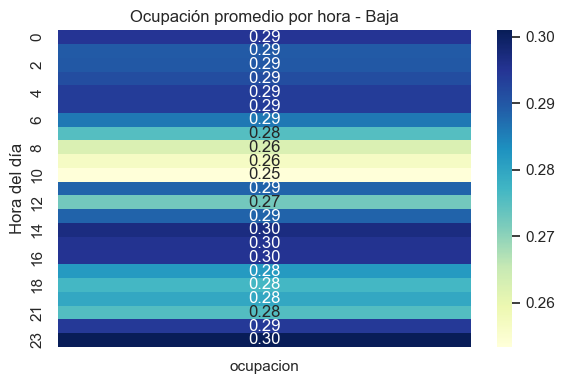

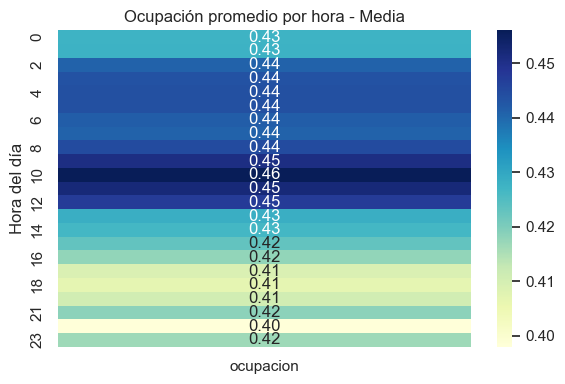

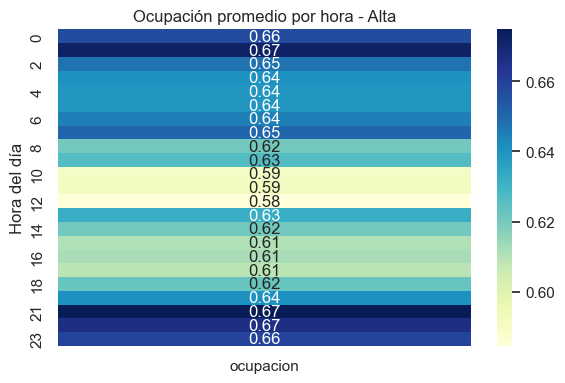

=== Mapas de calor: temperatura vs ocupación promedio ===


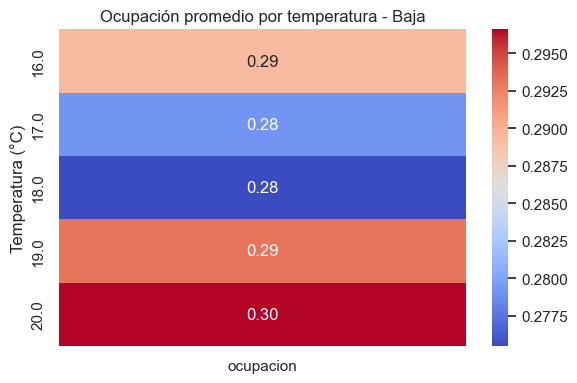

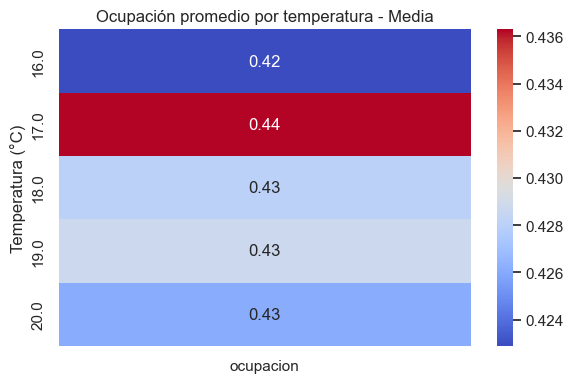

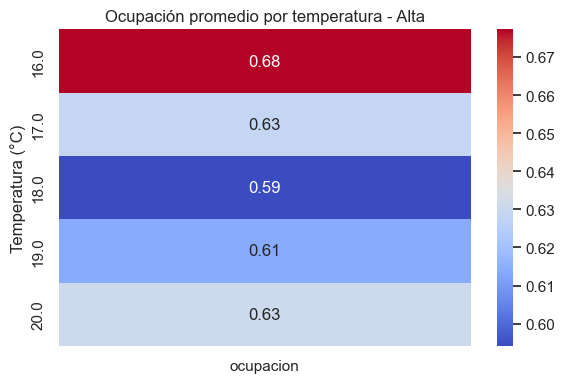

In [322]:
# ================================================
# 11. Mapas de calor por categoría de ocupación
# ================================================

# Aseguramos columnas correctas
df["hora"] = df["hora"].astype(int)
df["temp_c_redondeada"] = df["temp_c"].round()

# Filtrar datos válidos
df_filtrado = df.dropna(subset=["ocupacion", "hora", "temp_c_redondeada", "categoria_ocupacion"])

# Obtener categorías presentes
categorias = [c for c in labels if c in df_filtrado["categoria_ocupacion"].unique()]

# --- Mapas de calor por hora ---
print("=== Mapas de calor: hora vs ocupación promedio ===")
for cat in categorias:
    subset = df_filtrado[df_filtrado["categoria_ocupacion"] == cat]
    pivot_hora = subset.pivot_table(index="hora", values="ocupacion", aggfunc="mean")
    
    plt.figure(figsize=(6,4))
    sns.heatmap(pivot_hora, cmap="YlGnBu", annot=True, fmt=".2f")
    plt.title(f"Ocupación promedio por hora - {cat}")
    plt.ylabel("Hora del día")
    plt.xlabel("")
    plt.tight_layout()
    plt.show()

# --- Mapas de calor por temperatura ---
print("=== Mapas de calor: temperatura vs ocupación promedio ===")
for cat in categorias:
    subset = df_filtrado[df_filtrado["categoria_ocupacion"] == cat]
    pivot_temp = subset.pivot_table(index="temp_c_redondeada", values="ocupacion", aggfunc="mean").sort_index()
    
    plt.figure(figsize=(6,4))
    sns.heatmap(pivot_temp, cmap="coolwarm", annot=True, fmt=".2f")
    plt.title(f"Ocupación promedio por temperatura - {cat}")
    plt.ylabel("Temperatura (°C)")
    plt.xlabel("")
    plt.tight_layout()
    plt.show()


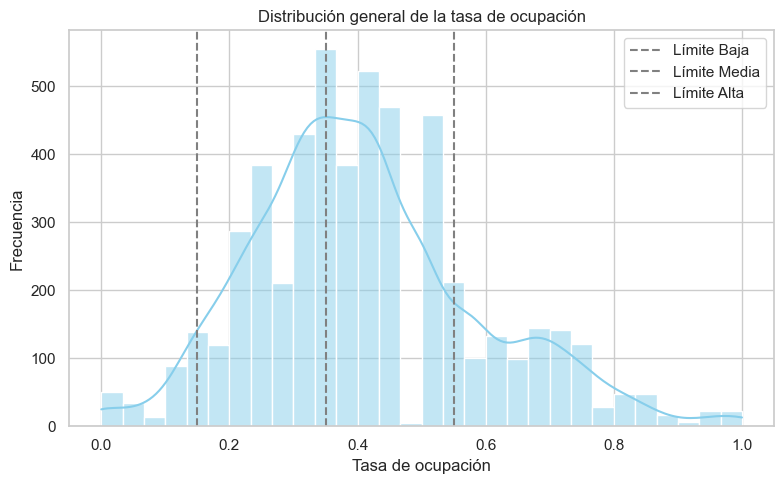

In [323]:

# ==========================================================
# VISUALIZACIONES
# ==========================================================

# --- 1️⃣ Histograma general de la tasa de ocupación ---
plt.figure(figsize=(8,5))
sns.histplot(df['ocupacion'], bins=30, kde=True, color='skyblue')
plt.axvline(0.15, color='gray', linestyle='--', label='Límite Baja')
plt.axvline(0.35, color='gray', linestyle='--', label='Límite Media')
plt.axvline(0.55, color='gray', linestyle='--', label='Límite Alta')
plt.title("Distribución general de la tasa de ocupación")
plt.xlabel("Tasa de ocupación")
plt.ylabel("Frecuencia")
plt.legend()
plt.tight_layout()
plt.show()





C:\Users\curay\AppData\Local\Temp\ipykernel_4512\3624110146.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=conteo_estaciones.index, y=conteo_estaciones.values, palette="Blues")


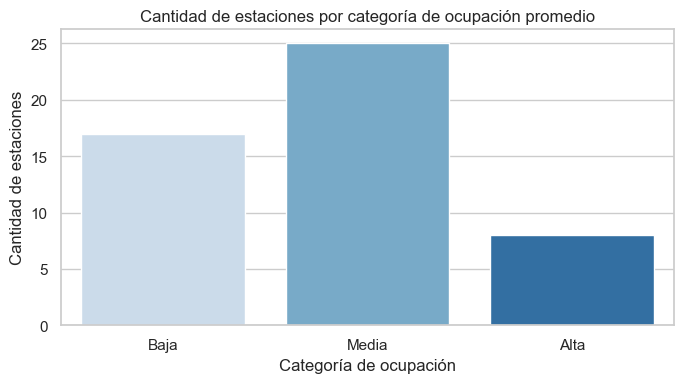

C:\Users\curay\AppData\Local\Temp\ipykernel_4512\3624110146.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


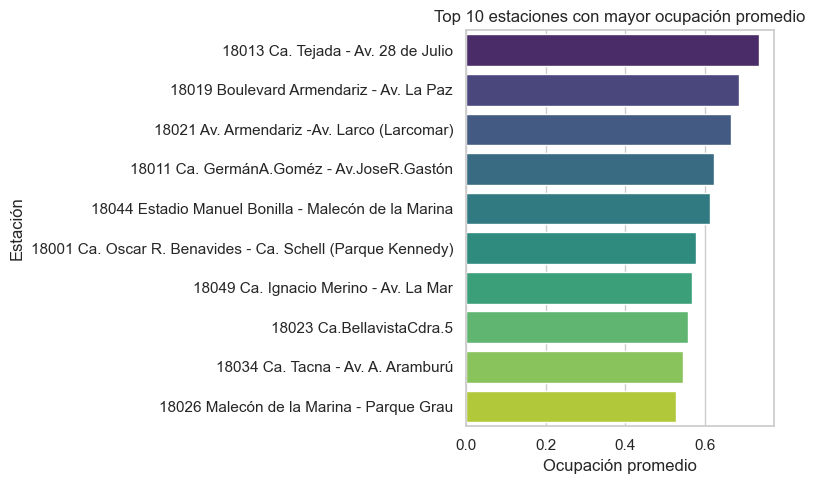

In [324]:

# ==========================================================
# OCUPACIÓN PROMEDIO POR ESTACIÓN Y CATEGORIZACIÓN
# ==========================================================
station_summary = df.groupby('id_estacion').agg(
    nombre_estacion=('nombre_estacion', 'first'),
    mean_ocupacion=('ocupacion', 'mean'),
    obs=('id_estacion', 'count')
).reset_index()

# Clasificamos cada estación según su ocupación promedio
bins = [0.15, 0.35, 0.55, 0.75]
labels = ['Baja','Media','Alta']
station_summary['ocup_cat_fixed'] = pd.cut(
    station_summary['mean_ocupacion'], 
    bins=bins, 
    labels=labels, 
    include_lowest=True
)
# VISUALIZACIÓN POR ESTACIONES


# --- 1️⃣ Conteo de estaciones por categoría ---
conteo_estaciones = station_summary['ocup_cat_fixed'].value_counts().reindex(labels)

plt.figure(figsize=(7,4))
sns.barplot(x=conteo_estaciones.index, y=conteo_estaciones.values, palette="Blues")
plt.title("Cantidad de estaciones por categoría de ocupación promedio")
plt.xlabel("Categoría de ocupación")
plt.ylabel("Cantidad de estaciones")
plt.tight_layout()
plt.show()



# --- 3️⃣ Ranking de estaciones ---
top_estaciones = station_summary.sort_values('mean_ocupacion', ascending=False).head(10)

plt.figure(figsize=(8,5))
sns.barplot(
    x='mean_ocupacion', 
    y='nombre_estacion', 
    data=top_estaciones, 
    palette="viridis"
)
plt.title("Top 10 estaciones con mayor ocupación promedio")
plt.xlabel("Ocupación promedio")
plt.ylabel("Estación")
plt.tight_layout()
plt.show()

C:\Users\curay\AppData\Local\Temp\ipykernel_4512\321513722.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


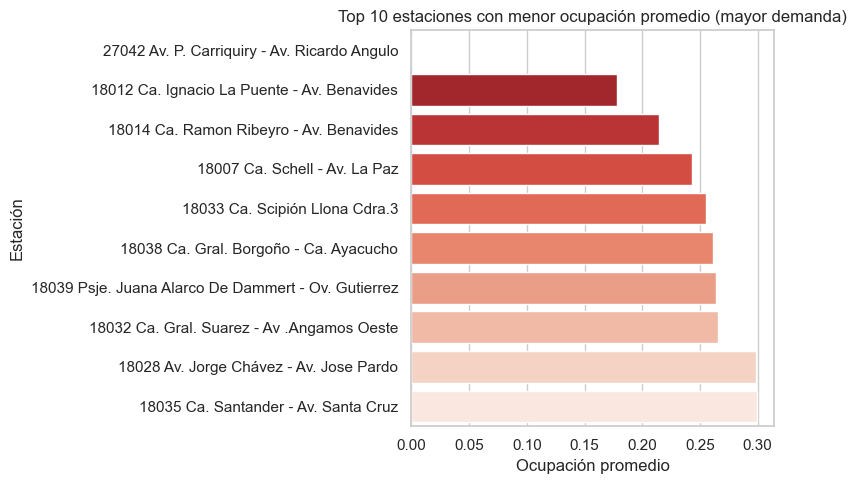

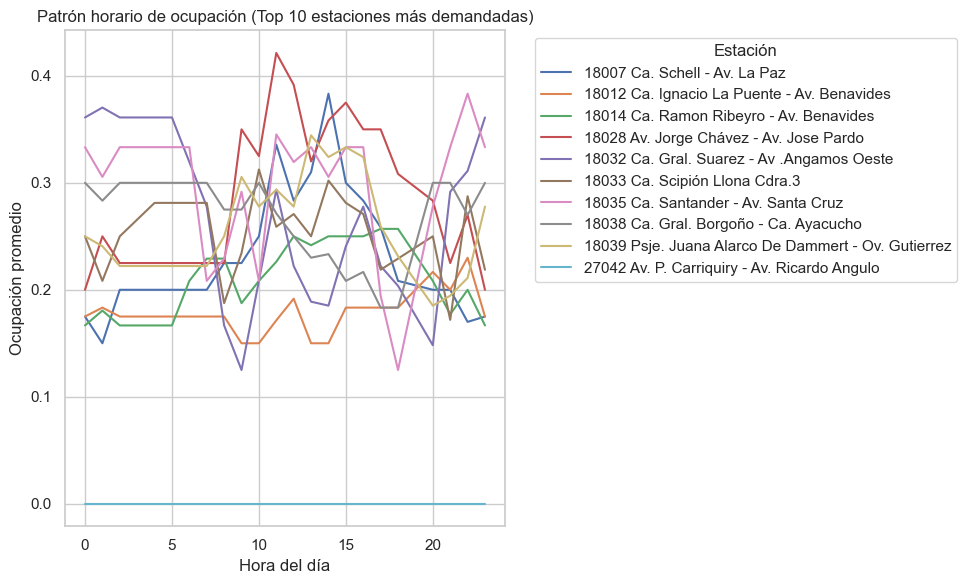

In [325]:
# ==========================================================
# 1️⃣ Estaciones con menor ocupación promedio (alta demanda)
# ==========================================================
bottom_estaciones = station_summary.sort_values('mean_ocupacion', ascending=True).head(10)

plt.figure(figsize=(8,5))
sns.barplot(
    x='mean_ocupacion',
    y='nombre_estacion',
    data=bottom_estaciones,
    palette="Reds_r"  # colores invertidos: rojo = más vacía
)
plt.title("Top 10 estaciones con menor ocupación promedio (mayor demanda)")
plt.xlabel("Ocupación promedio")
plt.ylabel("Estación")
plt.tight_layout()
plt.show()

# ==========================================================
# 2️⃣ Ocupación por hora para estaciones de alta demanda
# ==========================================================
# Filtramos el dataset original solo para esas estaciones
df_high_demand = df[df['id_estacion'].isin(bottom_estaciones['id_estacion'])]

ocup_hora = df_high_demand.groupby(['nombre_estacion','hora']).agg(
    ocupacion_promedio=('ocupacion','mean')
).reset_index()

plt.figure(figsize=(10,6))
sns.lineplot(data=ocup_hora, x='hora', y='ocupacion_promedio', hue='nombre_estacion')
plt.title("Patrón horario de ocupación (Top 10 estaciones más demandadas)")
plt.xlabel("Hora del día")
plt.ylabel("Ocupación promedio")
plt.legend(title="Estación", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()




Cantidad total de filas: 5250
Cantidad con avenida asignada: 5040
Cantidad sin avenida asignada: 210

Ejemplo de avenidas detectadas:
['Av. Pardo' 'Ca. Luis Schereiber Cdra' 'Ca. Madrid' 'Malecón Cisneros'
 'Malecón de la Marina' 'Malecón de la Reserva' 'Ca. Tacna'
 'Av. Armendariz' 'Av. Nuñez de Balboa' 'Ca. Manco Capac']


C:\Users\curay\AppData\Local\Temp\ipykernel_4512\351019502.py:47: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


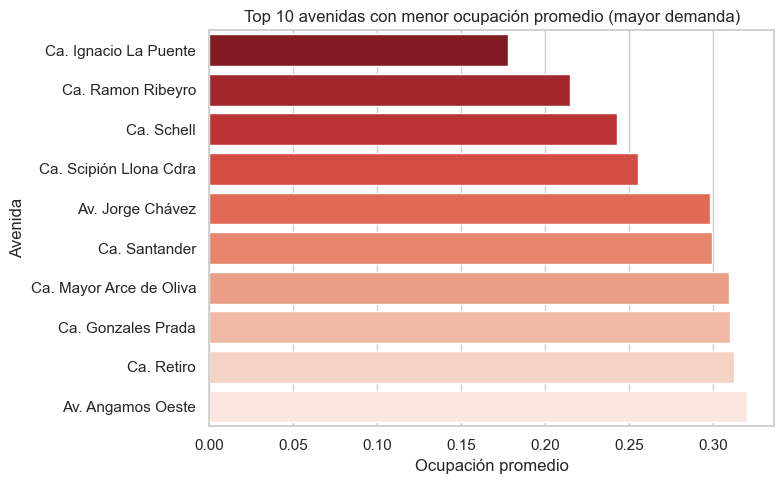

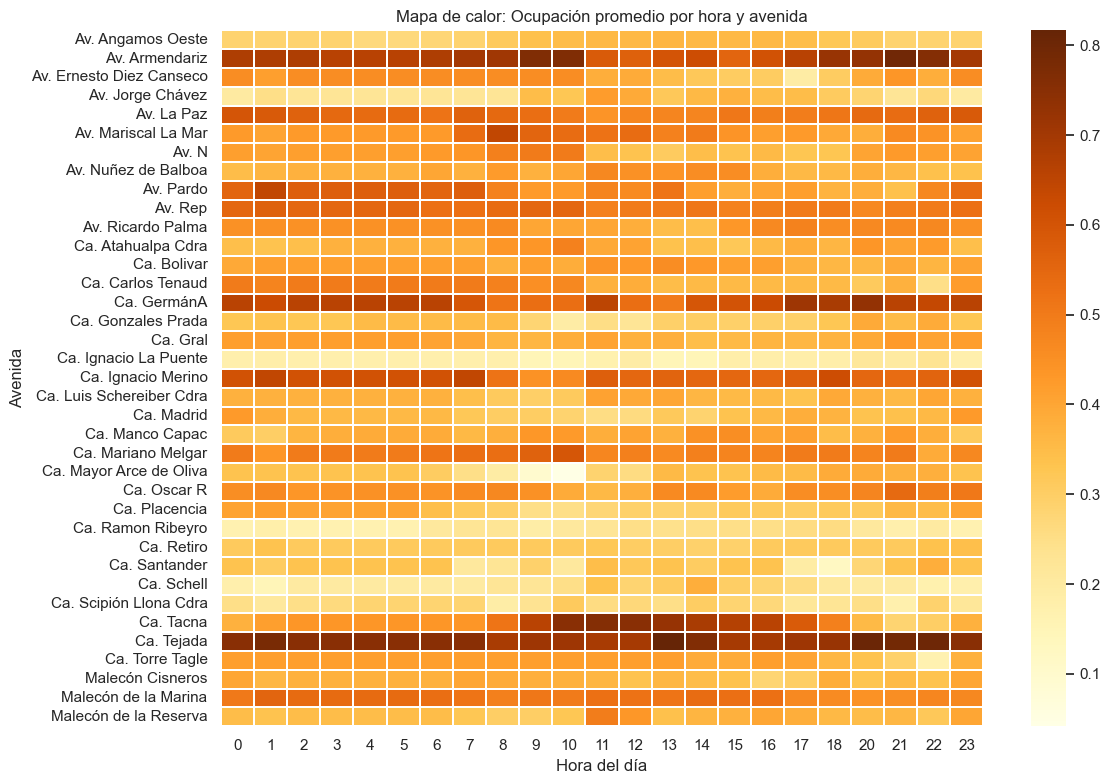

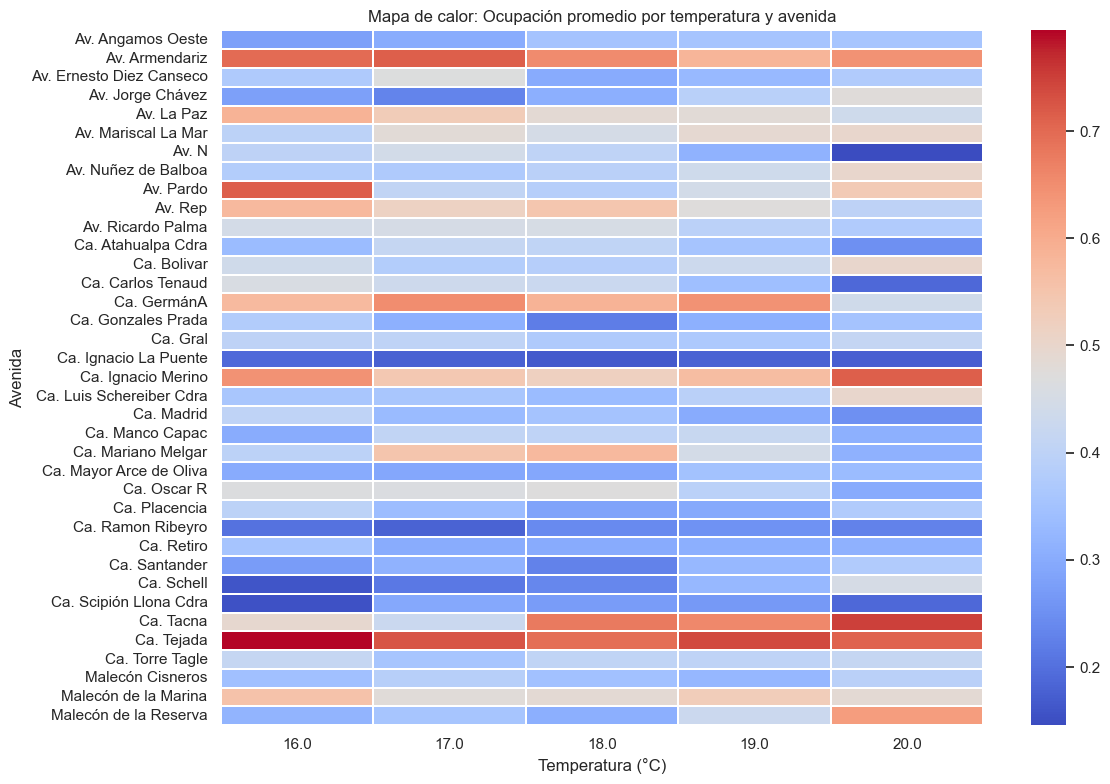

In [329]:
# ===============================================================
# 🚲 ANÁLISIS DE OCUPACIÓN PROMEDIO POR AVENIDA - CITYBIKE (versión automática)
# ===============================================================

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- 1️⃣ Filtrado básico de estaciones válidas ---
min_obs = 40  # mínimo de observaciones por estación
station_summary = df.groupby('id_estacion')['ocupacion'].agg(['count', 'mean']).reset_index()
station_summary.rename(columns={'count': 'obs', 'mean': 'ocup_prom'}, inplace=True)

good_stations = station_summary[station_summary['obs'] >= min_obs]['id_estacion']
df_filtered = df[df['id_estacion'].isin(good_stations)].copy()

# --- 2️⃣ Detectar avenida a partir del nombre de estación ---
# Intentamos extraer palabras clave como 'Av.', 'Ca.', 'Malecón', 'Parque', etc.
df_filtered['avenida'] = df_filtered['nombre_estacion'].str.extract(
    r'((?:Av\.|Avenida|Ca\.|Calle|Malecón|Parque)\s+[A-Za-zÁÉÍÓÚáéíóúñÑ\s]+)'
)

# Limpieza básica
df_filtered['avenida'] = df_filtered['avenida'].str.strip()

print("Cantidad total de filas:", len(df_filtered))
print("Cantidad con avenida asignada:", df_filtered['avenida'].notna().sum())
print("Cantidad sin avenida asignada:", df_filtered['avenida'].isna().sum())
print("\nEjemplo de avenidas detectadas:")
print(df_filtered['avenida'].dropna().unique()[:10])

# --- 3️⃣ Eliminar filas sin avenida ---
df_filtered = df_filtered.dropna(subset=['avenida'])

# --- 4️⃣ Promedio de ocupación por avenida ---
avenida_stats = (
    df_filtered.groupby('avenida')['ocupacion']
    .mean()
    .sort_values(ascending=True)
    .reset_index()
)

# --- 5️⃣ Top 10 de menor ocupación promedio (mayor demanda) ---
top10_baja_ocup = avenida_stats.head(10)

plt.figure(figsize=(8, 5))
sns.barplot(
    data=top10_baja_ocup,
    x='ocupacion',
    y='avenida',
    palette='Reds_r'
)
plt.title("Top 10 avenidas con menor ocupación promedio (mayor demanda)")
plt.xlabel("Ocupación promedio")
plt.ylabel("Avenida")
plt.tight_layout()
plt.show()

# --- 6️⃣ Mapa de calor: ocupación promedio por hora y avenida ---
pivot_hora = df_filtered.pivot_table(
    index='avenida',
    columns='hora',
    values='ocupacion',
    aggfunc='mean'
).dropna(how='all')

if not pivot_hora.empty:
    plt.figure(figsize=(12, 8))
    sns.heatmap(pivot_hora, cmap='YlOrBr', linewidths=0.3)
    plt.title("Mapa de calor: Ocupación promedio por hora y avenida")
    plt.xlabel("Hora del día")
    plt.ylabel("Avenida")
    plt.tight_layout()
    plt.show()
else:
    print("⚠️ No hay datos suficientes para el mapa de calor por hora.")

# --- 7️⃣ Mapa de calor: ocupación promedio por temperatura y avenida ---
df_filtered['temp_redondeada'] = df_filtered['temp_c'].round()
pivot_temp = df_filtered.pivot_table(
    index='avenida',
    columns='temp_redondeada',
    values='ocupacion',
    aggfunc='mean'
).dropna(how='all')

if not pivot_temp.empty:
    plt.figure(figsize=(12, 8))
    sns.heatmap(pivot_temp, cmap='coolwarm', linewidths=0.3)
    plt.title("Mapa de calor: Ocupación promedio por temperatura y avenida")
    plt.xlabel("Temperatura (°C)")
    plt.ylabel("Avenida")
    plt.tight_layout()
    plt.show()
else:
    print("⚠️ No hay datos suficientes para el mapa de calor por temperatura.")
